## Engineers' Salary Prediction Challenge

### Author: Hubert Kłosowski 242424

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Load data

In [19]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))

### <center>Skip job_desc</center>

In [20]:
train = train.loc[:, train.columns[:17]]
test = test.loc[:, test.columns[:16]]

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   obs              1280 non-null   int64  
 1   job_title        1280 non-null   object 
 2   job_posted_date  1279 non-null   object 
 3   salary_category  1280 non-null   object 
 4   job_state        1253 non-null   object 
 5   feature_1        1280 non-null   object 
 6   feature_2        1280 non-null   float64
 7   feature_3        1280 non-null   bool   
 8   feature_4        1280 non-null   bool   
 9   feature_5        1280 non-null   bool   
 10  feature_6        1280 non-null   bool   
 11  feature_7        1280 non-null   bool   
 12  feature_8        1280 non-null   bool   
 13  feature_9        1280 non-null   bool   
 14  feature_10       834 non-null    float64
 15  feature_11       1280 non-null   bool   
 16  feature_12       1280 non-null   bool   
dtypes: bool(9), fl

In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 854 entries, 0 to 853
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   obs              854 non-null    int64  
 1   job_title        854 non-null    object 
 2   job_posted_date  854 non-null    object 
 3   job_state        841 non-null    object 
 4   feature_1        854 non-null    object 
 5   feature_2        854 non-null    float64
 6   feature_3        854 non-null    bool   
 7   feature_4        854 non-null    bool   
 8   feature_5        854 non-null    bool   
 9   feature_6        854 non-null    bool   
 10  feature_7        854 non-null    bool   
 11  feature_8        854 non-null    bool   
 12  feature_9        854 non-null    bool   
 13  feature_10       540 non-null    float64
 14  feature_11       854 non-null    bool   
 15  feature_12       854 non-null    bool   
dtypes: bool(9), float64(2), int64(1), object(4)
memory usage: 54.3

### Extract date info

In [23]:
def extract_date_info(dataframe):
    dataframe['job_posted_date'] = pd.to_datetime(dataframe['job_posted_date'], format='mixed')
    dataframe['Month'] = dataframe['job_posted_date'].dt.month.astype('category')
    dataframe['Year'] = dataframe['job_posted_date'].dt.year.astype('category')
    dataframe['Season'] = get_season(dataframe['job_posted_date']).astype('category')
    return dataframe.drop(columns=['job_posted_date'])

def get_season(date_series):
    spring = ((date_series.dt.month == 3) & (date_series.dt.day >= 20)) | ((date_series.dt.month > 3) & (date_series.dt.month < 6)) | ((date_series.dt.month == 6) & (date_series.dt.day <= 20))
    summer = ((date_series.dt.month == 6) & (date_series.dt.day >= 21)) | ((date_series.dt.month > 6) & (date_series.dt.month < 9)) | ((date_series.dt.month == 9) & (date_series.dt.day <= 22))
    autumn = ((date_series.dt.month == 9) & (date_series.dt.day >= 23)) | ((date_series.dt.month > 9) & (date_series.dt.month < 12)) | ((date_series.dt.month == 12) & (date_series.dt.day <= 20))
    
    season_series = pd.Series(0, index=date_series.index)  # Domyślnie 0 dla wiosny
    season_series.loc[summer] = 1  # Lato
    season_series.loc[autumn] = 2  # Jesień
    season_series.loc[~(spring | summer | autumn)] = 3  # Zima
    return season_series


train = extract_date_info(train)
test = extract_date_info(test)

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   obs              1280 non-null   int64   
 1   job_title        1280 non-null   object  
 2   salary_category  1280 non-null   object  
 3   job_state        1253 non-null   object  
 4   feature_1        1280 non-null   object  
 5   feature_2        1280 non-null   float64 
 6   feature_3        1280 non-null   bool    
 7   feature_4        1280 non-null   bool    
 8   feature_5        1280 non-null   bool    
 9   feature_6        1280 non-null   bool    
 10  feature_7        1280 non-null   bool    
 11  feature_8        1280 non-null   bool    
 12  feature_9        1280 non-null   bool    
 13  feature_10       834 non-null    float64 
 14  feature_11       1280 non-null   bool    
 15  feature_12       1280 non-null   bool    
 16  Month            1279 non-null   category


### Why NaNs in feature_10

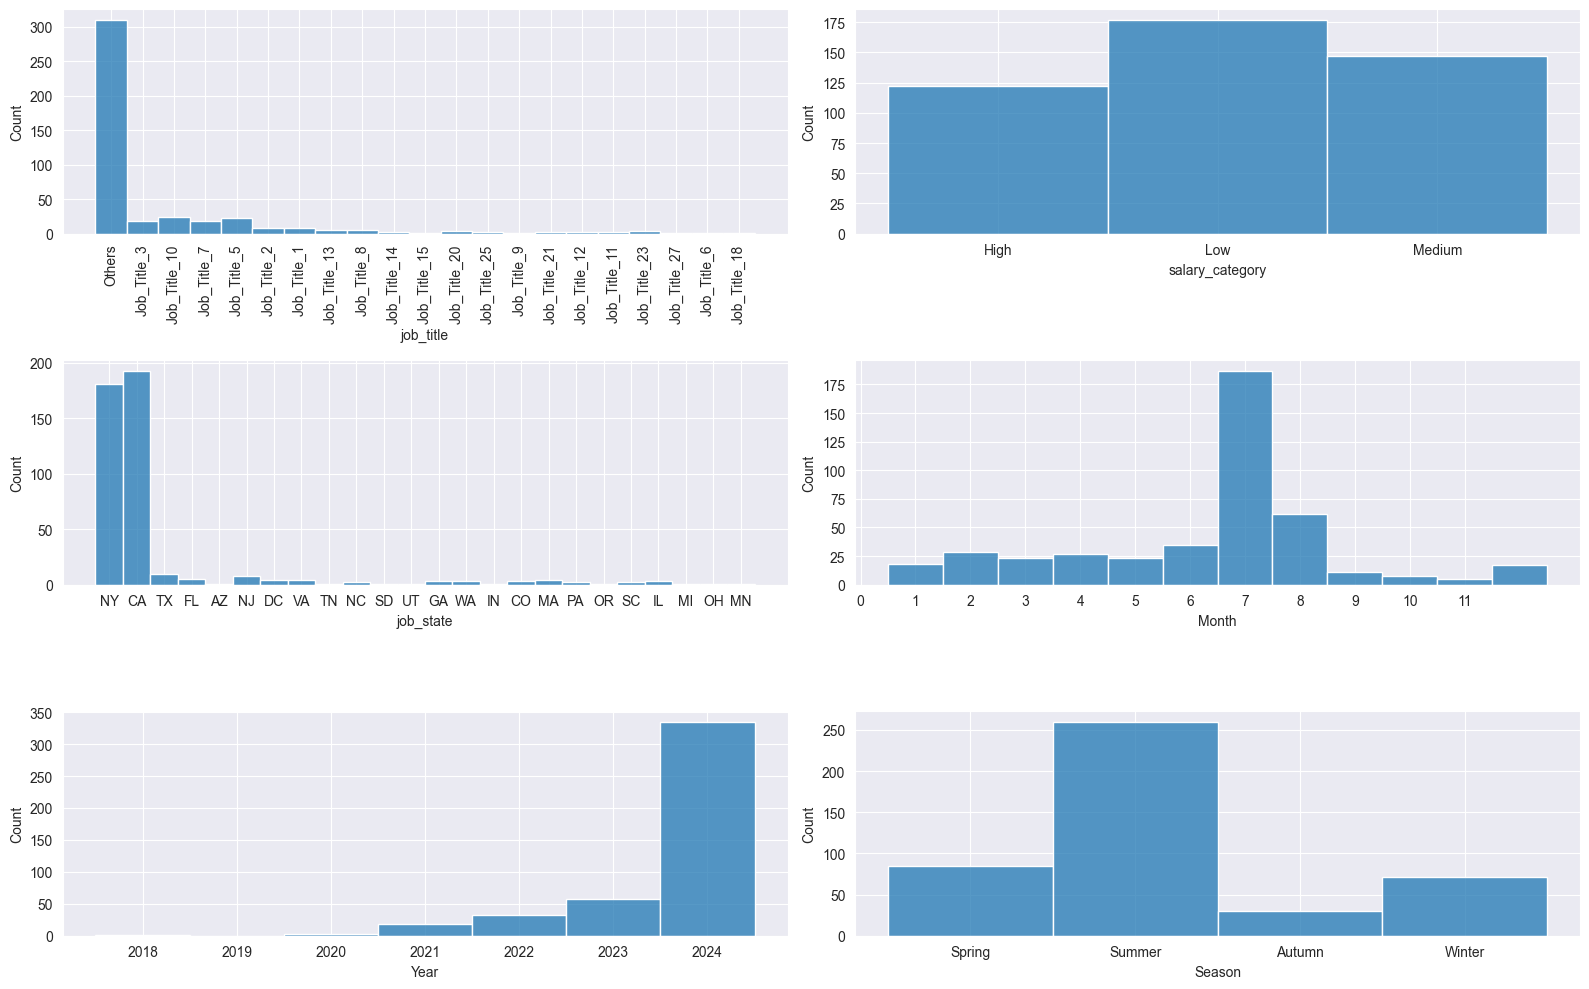

In [25]:
feature_10_nans = train.loc[train['feature_10'].isna(), :]

columns = [col for col in feature_10_nans.columns[1:] if 'feature' not in col]

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 10))

for i, col in enumerate(columns):
    x_cord, y_cord = divmod(i, 2)
    p = sns.histplot(x=feature_10_nans[col], ax=ax[x_cord, y_cord])
    if i == 0:
        ax[x_cord, y_cord].tick_params(axis='x', rotation=90)
    if i == 3:
        p.set_xticks(range(12))
    if i == 5:
        p.set_xticks(range(4), ['Spring', 'Summer', 'Autumn', 'Winter'])

plt.tight_layout()
plt.show()

### Distribution of values

<Axes: xlabel='salary_category', ylabel='Count'>

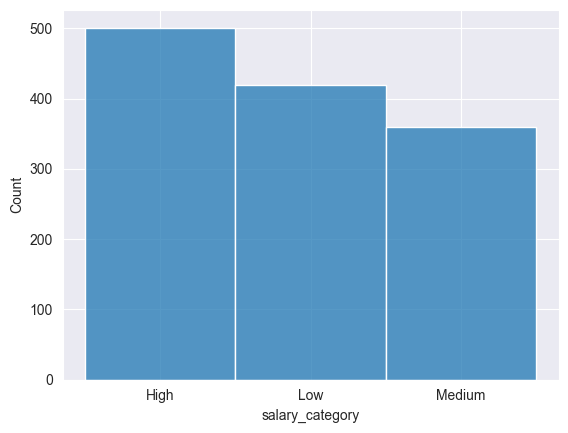

In [26]:
sns.histplot(data=train, x='salary_category')

### Prepare data

In [27]:
train['job_title'].replace(to_replace=r'^title.$', value='has_job', regex=True)

test_ids = test['obs']
train.drop(columns=['obs', 'feature_1', 'feature_10'], axis=1, inplace=True)
test.drop(columns=['obs', 'feature_1', 'feature_10'], axis=1, inplace=True)

### Check ranges of values

In [28]:
train.describe()

,feature_2
count,1280.000000
mean,0.592414
std,0.108669
min,0.377300
25%,0.470400
50%,0.599500
75%,0.685425
max,0.906300


### Make the same ranges for test and train

In [29]:
def cut_ranges():
    for column in test.select_dtypes(exclude=['category']).columns[2:]:
        test_min = test[column].min()
        test_max = test[column].max()
        to_drop = train[(train[column] < test_min) | (train[column] > test_max)].index
        train.drop(index=to_drop, inplace=True)


cut_ranges()

train.describe()

,feature_2
count,1275.000000
mean,0.592791
std,0.107950
min,0.412700
25%,0.471400
50%,0.599700
75%,0.685550
max,0.895400


### Correlation Matrix for train

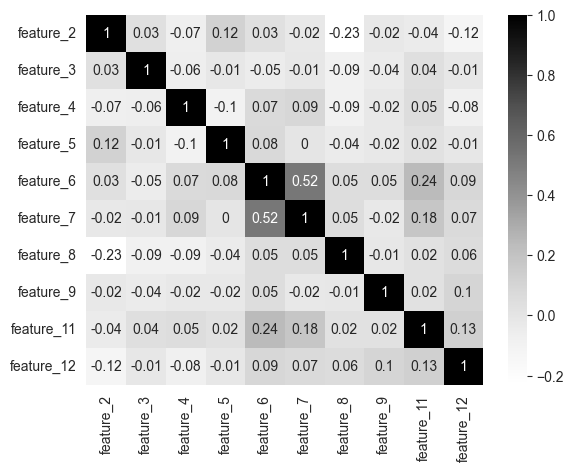

In [30]:
sns.heatmap(train.corr(numeric_only=True).round(2), annot=True, cmap='Greys')
plt.show()

### Correlation Matrix for test

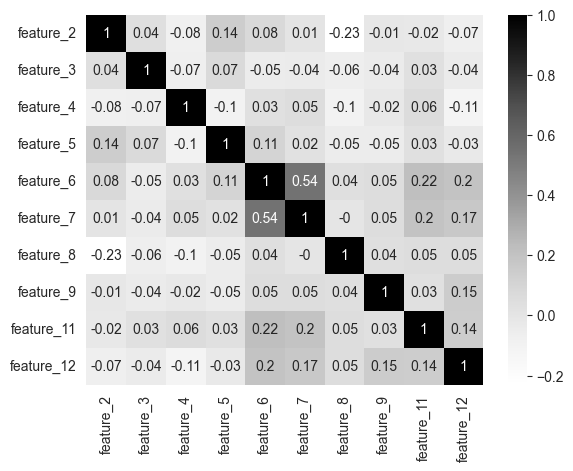

In [31]:
sns.heatmap(test.corr(numeric_only=True).round(2), annot=True, cmap='Greys')
plt.show()